# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# Импортируем библиотеки
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np


In [2]:
#Загружаем данные
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255.)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe(include= 'all')

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,003206.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


In [6]:
labels.shape

(7591, 2)

In [7]:
#При помощи функции next получим features и target из загруженных данных
features, target = next(train_gen_flow)

In [8]:
features.shape

(32, 224, 224, 3)

В нашем расоряжении выборка с цветными фотографиями в количестве 7591 шт. и размером 224x224 разделённая на множество слоёв (батчей) по 32 тренировочных объекта в каждом. Таким образом если обучать весь датасет, то нам потребуется 237 итреаций на одну эпоху.

# Построим график распределения возростов в нашей выборке

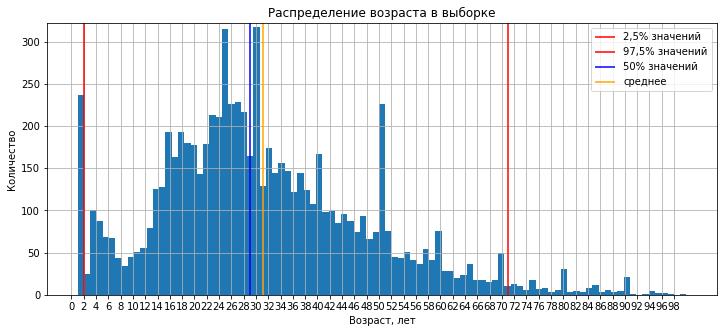

In [9]:
labels['real_age'].hist(bins = len(labels['real_age'].unique()),
                     figsize = (12,5))
plt.vlines(
    x = labels['real_age'].quantile(0.025),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '2,5% значений'
)

plt.vlines(
    x = labels['real_age'].quantile(0.975),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '97,5% значений'
)

plt.vlines(
    x = labels['real_age'].quantile(0.5),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'b',
    label = '50% значений'
)

plt.vlines(
    x = labels['real_age'].mean(),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'orange',
    label = 'среднее'
)

plt.title('Распределение возраста в выборке')
plt.ylim(top = labels['real_age'].value_counts().max()+5)
plt.legend()
plt.ylabel('Количество')
plt.xticks(range(0, labels['real_age'].max(), 2))
plt.xlabel('Возраст, лет')
plt.show()

# Посмотрим на концентрацию данных о возрасте при помощи графика boxplot

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


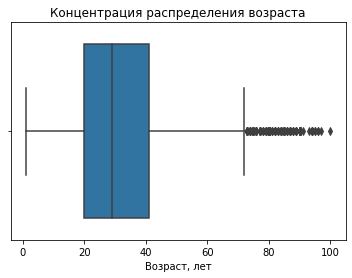

In [10]:
sns.boxplot(labels["real_age"])
plt.title('Концентрация распределения возраста')
plt.xlabel('Возраст, лет')
plt.show()

In [11]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255,
                                    horizontal_flip=True)
    
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 

test_datagen = ImageDataGenerator(
                                        validation_split=0.25,
                                        rescale=1./255)
    
test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 


Found 5694 validated image filenames.
Found 1897 validated image filenames.


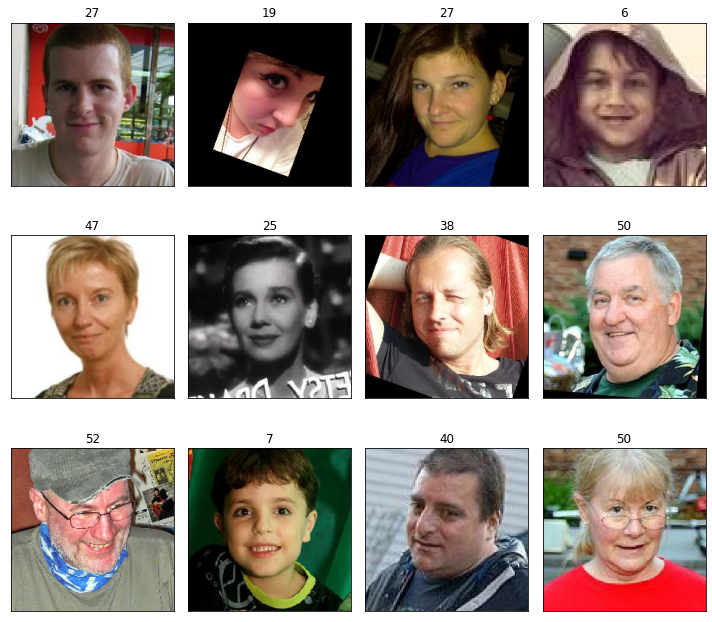

In [12]:
x, y = next(train_gen_flow)
fig = plt.figure(figsize = (10,10))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# Вывод

В нашем распоряжении датасет с размеченными фотографиями в количеств 7591 шт. и размером 224 на 224 , этого количества вполне достаточно для того, чтобы попробовать провести обучение нашей модели без заморозки основного слоя сети и избежать переобучения. Среди них много повернутых изображений по горизонтали(и поэтому мы должны добавить изображения с увеличенным вращением в тренировочную выборку), а также мы видим изображения в оттенках серого и красного, очень редко встречаются фото с размытием области. Такие фотографии конечно же усложнят работу модели по определению точного возраста, но подавляющее большинство фотографий всё же выполнено в нормальном цветовом спектре. Для фото с недостаточной яркостью применим дополнительный параметр по добавлению фото с пониженой яркостью в тренировочную выборку.

Судя по гистограмме распределения семплов мы можем увидеть нормальне распределение возростных данных со скосом вправо. При этом выделяются пиковые года в области юбилейных дат и знаковых порогов жизни, таких как: первого года жизни, 18 лет, 30 лет, 40, 60 и т.д. В нашем датасете мы имеем преобладающее большинство размеченных фотографий с возрастом от 20 до 40 лет с пиковым значением в 30 лет. Такое распределение связано с тем, что молодые люди до 30 лет ведут активный образ жизни, параллельно делая много разноплановых фотографий. Люди после 30 лет уже ведут более размеренную жизнь и ярких событий, которые хотетелось бы запечатлеть на фото, становится всё меньше. Соответственно наша модель будет давать более точные прогнозы на фотографиях людей в возрасте от 20 до 40 лет

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

# Код обучения модели

```python


import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255,
                                    horizontal_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(
                                        validation_split=0.25,
                                        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer=Adam(learning_rate=0.0001)
 
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsoluteError(), 
              metrics=['mae']) 
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255,
                                    horizontal_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(
                                        validation_split=0.25,
                                        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer=Adam(learning_rate=0.0001)
 
    model.compile(optimizer=optimizer, loss='mse', 
              metrics=['mae']) 
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

# Результат работы модели вывод на экран

**Лучший результат MAE на тестовой выборке: 6.43 достигнут при 3 эпохах обучения**

## Анализ обученной модели

Перед нами стояла задача построить и обучить модель, которя поможет определять возраст человека по изображению с камеры со средним абсолютным отклонением  MAE не выше 7.

В нашем распоряжении был датасет с 7591 размеченной фотографией, среди которых преимущественно были фотографии выполненные при слабом освещении и с вращением по горизонтальной оси. Для того, чтобы модель обучилась точнее мы предварительно отделив 75% данных для тренировки модели, использовали специальные гиперпараметры, которые добавили в тренировочную выборку фотографии с похожими эффектами, а оставшиеся 25% оставили без изменений для тестирования модели.

В качестве основы за модель взяли уже предобученную нейросеть с архитектурой **ResNet50**и дополнительно обучили её на наших данных без замораживания. В выходном слое,для более точного обучения модели, использовали оптимизацию **Adam** c шагом обучения , а в качестве функции потерь использовалась **mse**, что немного ускорило процесс обучения.


С такими параметрами мы протестировали нашу модель на 3 эпохе обучения на тестовых данных, она достигла значения по метрике **MAE** равное 6.43, что существенно меньше 7. 

Таким образом мы достигли требуемой точности предсказания возраста нашей моделью и смело можем рекомендовать её к использованию.